In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurements = Base.classes.measurement
Stations = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

identifying columns in measurement table

In [9]:
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


identifying columns in station table

In [10]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Find the most recent date in the data set.
session.query(Measurements.date).order_by(Measurements.date.desc()).first()


('2017-08-23')

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
end_date = session.query(Measurements.date).order_by(Measurements.date.desc()).first()
end_date
# Calculate the date one year from the last date in data set.
start_date = dt.date(2017,8,23)- dt.timedelta(days=365)
start_date
# Perform a query to retrieve the data and precipitation scores
query = [Measurements.date,Measurements.prcp]
weather_data = session.query(*query).\
                        filter(Measurements.date >= start_date).all()

weather_df = pd.DataFrame(weather_data, columns=['date', 'prcp'])
weather_df.head()
end_date

('2017-08-23')

Plot of all precipitation data over 12 months

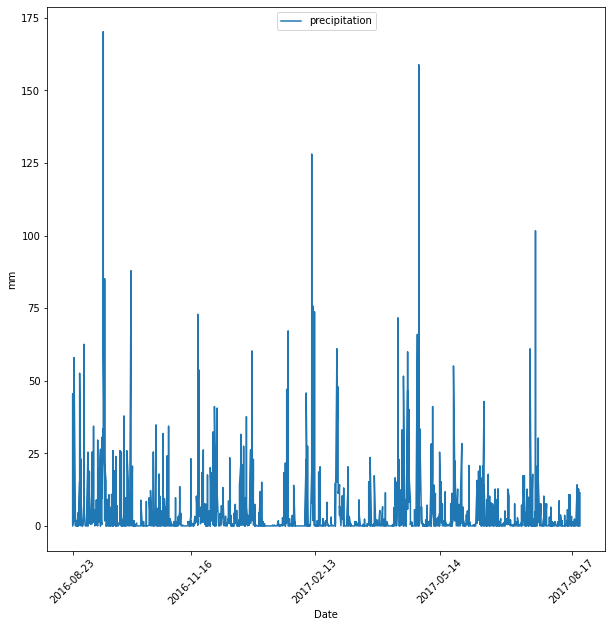

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
#weather_df = pd.DataFrame(weather_data, columns=['date', 'prcp'])
# Sort the dataframe by date
weather_df = weather_df.sort_values(by='date').dropna()
weather_df
# Use Pandas Plotting with Matplotlib to plot the data
x = weather_df['date']
y = weather_df['prcp']
plt.figure(figsize=(10,10))
plt.plot(x,y)
plt.legend(['precipitation'], loc='upper center')
plt.xlabel('Date')
plt.xticks(x[::500],  rotation=45)
plt.ylabel('mm')
plt.show()


In [14]:
weather_df.head(20)

,date,prcp
0,2016-08-23,0.0
1529,2016-08-23,45.5
704,2016-08-23,1.3
361,2016-08-23,3.8
1881,2016-08-23,17.8
1192,2016-08-23,0.5
1,2016-08-24,2.0
1530,2016-08-24,54.6
705,2016-08-24,57.9
1882,2016-08-24,36.8


In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
round(weather_df.describe(),2)

,prcp
count,2021.00
mean,4.51
std,11.71
min,0.00
25%,0.00
50%,0.50
75%,3.30
max,170.20


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count(Stations.id)).all()

[(9)]

In [17]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
query2 = [Measurements.station, func.count(Measurements.station)]

station_activity = session.query(*query2).\
    group_by(Measurements.station).all()
station_activity

[('USC00511918', 1979),
 ('USC00513117', 2709),
 ('USC00514830', 2202),
 ('USC00516128', 2612),
 ('USC00517948', 1372),
 ('USC00518838', 511),
 ('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00519523', 2669)]

In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
query3 = [Measurements.station, func.min(Measurements.tobs), func.max(Measurements.tobs), func.avg(Measurements.tobs)]

USC00519281_summary = session.query(*query3).\
    filter(Measurements.station == 'USC00519281').all()

USC00519281_summary_df = round(pd.DataFrame(USC00519281_summary, columns=['Station', 'Min Temp', 'Max Temp', 'Ave Temp']),2)
USC00519281_summary_df

,Station,Min Temp,Max Temp,Ave Temp
0,USC00519281,12.2,29.4,22.04


Finding the most recent date entry for station USC00519281

In [19]:
session.query(func.max(Measurements.date)).\
    filter(Measurements.station == 'USC00519281').all()

[('2017-08-18')]

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query4 = [Measurements.date, Measurements.tobs]

st_date = dt.date(2017,8,18)- dt.timedelta(days=365)

USC00519281_data = session.query(*query4).\
    filter(Measurements.station == 'USC00519281').\
    filter(Measurements.date >= st_date).all()

USC00519281_df = pd.DataFrame(USC00519281_data, columns=['date', 'tobs'])
USC00519281_df

,date,tobs
0,2016-08-18,26.7
1,2016-08-19,26.1
2,2016-08-20,27.2
3,2016-08-21,26.1
4,2016-08-22,25.6
...,...,...
352,2017-08-14,25.0
353,2017-08-15,25.0
354,2017-08-16,24.4
355,2017-08-17,24.4


Station: USC00519281 dataframe with dates and tobs sorted by date

In [21]:
USC00519281_df = USC00519281_df.sort_values(by='date').dropna()
USC00519281_df

,date,tobs
0,2016-08-18,26.7
1,2016-08-19,26.1
2,2016-08-20,27.2
3,2016-08-21,26.1
4,2016-08-22,25.6
...,...,...
352,2017-08-14,25.0
353,2017-08-15,25.0
354,2017-08-16,24.4
355,2017-08-17,24.4


Histogram of Temperture data over 12 months from station: USC00519281

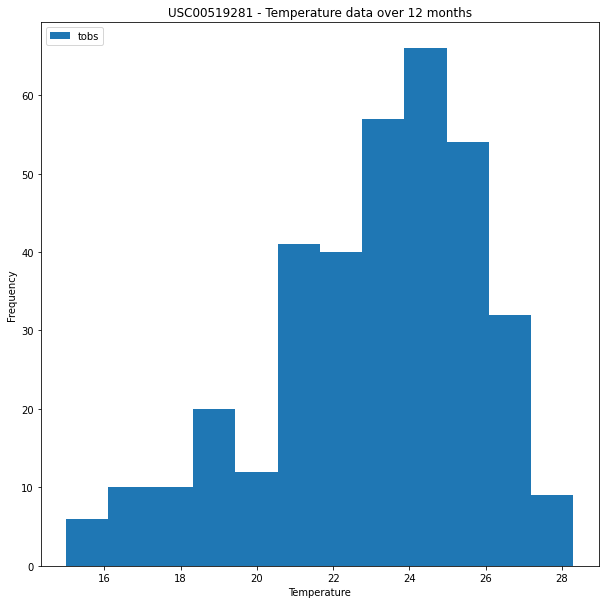

In [22]:
plt.figure(figsize=(10, 10))
plt.hist(USC00519281_df['tobs'], bins=12)
plt.legend(['tobs'], loc='upper left')
plt.title("USC00519281 - Temperature data over 12 months")
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.show()

# Close session

In [23]:
# Close Session
session.close()